In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import astropy as ap
from astropy.io import ascii
from astropy.io.ascii import masked
from pylab import *
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import ephem

# Astropy and requests imports
import urllib.parse
from html import unescape
import requests

from astropy.coordinates import SkyCoord
#import astropy.io.fits as fits
#import astropy.units as u
#from astropy.table import Table

# VO astroquery module
from navo_utils.registry import Registry
from navo_utils.image import Image, ImageColumn
from navo_utils.spectra import Spectra, SpectraColumn
from navo_utils.cone import Cone
from navo_utils.tap import Tap
from navo_utils.utils import astropy_table_from_votable_response

# Utility functions used in the workshop.
import workshop_utils.utils

## Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore")

Using this 4-class diverging color scheme that's colorblind safe, 
print friendly, and photocopy safe: http://colorbrewer2.org/#type=diverging&scheme=PuOr&n=4

# Constants Used

In [2]:
#---------------------------------------------------------
#Constants, taken from mass_SFR.py done by former students
#---------------------------------------------------------
Mag_sun_w1 = 3.254
Mag_sun_error_w1 = np.sqrt(0.008**2+0.02**2) #extra 0!!
Mag_sun_kt = 3.302
Mag_sun_error_kt = np.sqrt(0.008**2+0.02**2)
lum_sun = 3.828e26 #in W from NASA fact sheet
c = const.c.to('km/s').value #c in km/s
nu_3 = (c*1000)/(11.5608e-6) #in s^-1 from Table 1 in Jarrett et al. (2011) (link: http://iopscience.iop.org/article/10.1088/0004-637X/735/2/112/pdf)
zp_3 = 31.674 #in Jy Table 1 this WISE guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
a_3 = [1.13, 10.24] #Cluver14
a_4 = [0.82, 7.3] #Cluver14
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
h0_error = 2.4 # km/(Mpc*s)
parsec = 3.08567758e16 #m
jansky = 1e-26 #W/m^2/Hz

# Import/organize catalog from Holwerda et al. (2015)

In [3]:
#Read in the original Holwerda et al. (2015) data set, all pairs
data = pd.read_csv("data/holwerda15.csv")

#Filter into pair categories: PG+ELG, PG+PG, ELG+PG, ELG+ELG
pg_elg_pairs = data[data["spec_type"] == "PG+ELG"]
pg_pg_pairs = data[data["spec_type"] == "PG+PG"]
elg_pg_pairs = data[data["spec_type"] == "ELG+PG"]
elg_elg_pairs = data[data["spec_type"] == "ELG+ELG"]
# print(pg_elg_pairs.ra)

#Isolate RA, Dec, z1 (lense), z2 (source) by pair categories: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG
all_pairs = data[["ra","dec","z1","z2","spec_type","cataid"]]
all_pairs.to_csv("original_data.csv")
# print(all_pairs.ra)

#Isolate z1 (lense), z2 (source) for all pairs
#z1_all_pairs = data["z1"]
#print(z1_all_pairs)
#z2_all_pairs = data["z2"]

#Isolate z1 (lense), z2 (source) for PG+ELG pairs
z1_pg_elg_pairs = pg_elg_pairs["z1"]
z2_pg_elg_pairs = pg_elg_pairs["z2"]

#Isolate z1 (lense), z2 (source) for PG+PG pairs
z1_pg_pg_pairs = pg_pg_pairs["z1"]
z2_pg_pg_pairs = pg_pg_pairs["z2"]

#Isolate z1 (lense), z2 (source) for ELG+PG pairs
z1_elg_pg_pairs = elg_pg_pairs["z1"]
z2_elg_pg_pairs = elg_pg_pairs["z2"]

#Isolate z1 (lense), z2 (source) for ELG+ELG pairs
z1_elg_elg_pairs = elg_elg_pairs["z1"]
z2_elg_elg_pairs = elg_elg_pairs["z2"]

#-----------------------------------------------------------------------------------------------------
#Getting a list of galaxy pairs that are very close to each other (zdiff < 0.005)
#-----------------------------------------------------------------------------------------------------
close_pairs = all_pairs[abs(all_pairs["z1"]-all_pairs["z2"]) < 0.005]
# print(close_pairs)

# TO DO -- how close is close enough to be considered a merger? 

# TO DO -- show the KiDS cut outs for each cataid that is considered a close pair

# TO DO -- retrieve X-ray cut outs of matching cataid's in some other survey (Chandra?)... any strange activity?

# TO DO -- show the spectra for lensing and lensed galaxies for each close pair

# Import WISE data

In [4]:
#--------------------------------------------------------------------
# Read in results from all_pairs_targets.tbl upload for entire sample
#--------------------------------------------------------------------
all_pairs_results = "data/all_wise_results/all_pairs_results.tbl"
wise_data_all_pairs = ap.io.ascii.read(all_pairs_results, data_start=0, delimiter='|')
df_all_pairs = wise_data_all_pairs.to_pandas()

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_all_pairs.ra_01 = df_all_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_all_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
merged_data_all_pairs = pd.merge(df_all_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
#merged_data.to_csv('merged_data.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
z1_all_pairs = merged_data_all_pairs.z1
z2_all_pairs = merged_data_all_pairs.z2
w1_all_pairs = merged_data_all_pairs.w1mpro
#print(w1_all_pairs)
w2_all_pairs = merged_data_all_pairs.w2mpro
w3_all_pairs = merged_data_all_pairs.w3mpro
w1flux_all_pairs = merged_data_all_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from pg_elg_pairs_targets.tbl upload, PG+ELG only
#--------------------------------------------------------------------
pg_elg_pairs_results = "data/all_wise_results/pg_elg_results.tbl"
wise_data_pg_elg_pairs = ap.io.ascii.read(pg_elg_pairs_results, data_start=0, delimiter='|')
df_pg_elg_pairs = wise_data_pg_elg_pairs.to_pandas()

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_pg_elg_pairs.ra_01 = df_pg_elg_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_pg_elg_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
merged_data_pg_elg_pairs = pd.merge(df_pg_elg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
#merged_data_pg_elg_pairs.to_csv('merged_data_pg_elg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
z1_pg_elg_pairs = merged_data_pg_elg_pairs.z1
z2_pg_elg_pairs = merged_data_pg_elg_pairs.z2
w1_pg_elg_pairs = merged_data_pg_elg_pairs.w1mpro
w2_pg_elg_pairs = merged_data_pg_elg_pairs.w2mpro
w1flux_pg_elg_pairs = merged_data_pg_elg_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from pg_pg_pairs_targets.tbl upload, PG+PG only
#--------------------------------------------------------------------
pg_pg_pairs_results = "data/all_wise_results/pg_pg_results.tbl"
wise_data_pg_pg_pairs = ap.io.ascii.read(pg_pg_pairs_results, data_start=0, delimiter='|')
df_pg_pg_pairs = wise_data_pg_pg_pairs.to_pandas()

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_pg_pg_pairs.ra_01 = df_pg_pg_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_pg_pg_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
merged_data_pg_pg_pairs = pd.merge(df_pg_pg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
#merged_data_pg_pg_pairs.to_csv('merged_data_pg_pg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
z1_pg_pg_pairs = merged_data_pg_pg_pairs.z1
z2_pg_pg_pairs = merged_data_pg_pg_pairs.z2
w1_pg_pg_pairs = merged_data_pg_pg_pairs.w1mpro
w2_pg_pg_pairs = merged_data_pg_pg_pairs.w2mpro
cataid=pd.DataFrame(merged_data_all_pairs.cataid)
#print(cataid)
w1flux_pg_pg_pairs = merged_data_pg_pg_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from elg_pg_pairs_targets.tbl upload, ELG+PG only
#--------------------------------------------------------------------
elg_pg_pairs_results = "data/all_wise_results/elg_pg_results.tbl"
wise_data_elg_pg_pairs = ap.io.ascii.read(elg_pg_pairs_results, data_start=0, delimiter='|')
df_elg_pg_pairs = wise_data_elg_pg_pairs.to_pandas()

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_elg_pg_pairs.ra_01 = df_elg_pg_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_elg_pg_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
merged_data_elg_pg_pairs = pd.merge(df_elg_pg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
#merged_data_elg_pg_pairs.to_csv('merged_data_elg_pg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
z1_elg_pg_pairs = merged_data_elg_pg_pairs.z1
z2_elg_pg_pairs = merged_data_elg_pg_pairs.z2
w1_elg_pg_pairs = merged_data_elg_pg_pairs.w1mpro
w2_elg_pg_pairs = merged_data_elg_pg_pairs.w2mpro
w1flux_elg_pg_pairs = merged_data_elg_pg_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from elg_elg_pairs_targets.tbl upload, ELG+ELG only
#--------------------------------------------------------------------
elg_elg_pairs_results = "data/all_wise_results/elg_elg_results.tbl"
wise_data_elg_elg_pairs = ap.io.ascii.read(elg_elg_pairs_results, data_start=0, delimiter='|')
df_elg_elg_pairs = wise_data_elg_elg_pairs.to_pandas()

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_elg_elg_pairs.ra_01 = df_elg_elg_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_elg_elg_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
merged_data_elg_elg_pairs = pd.merge(df_elg_elg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
#merged_data_elg_elg_pairs.to_csv('merged_data_elg_elg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
z1_elg_elg_pairs = merged_data_elg_elg_pairs.z1
z2_elg_elg_pairs = merged_data_elg_elg_pairs.z2
w1_elg_elg_pairs = merged_data_elg_elg_pairs.w1mpro
w2_elg_elg_pairs = merged_data_elg_elg_pairs.w2mpro
w1flux_elg_pg_pairs = merged_data_elg_pg_pairs.w1flux

# Import NED Data

In [5]:
# Read in the list of galaxies.
list_of_galaxies = ascii.read('data/PG_ELG_pairs.csv', delimiter=',')    

# Create a list of coordinate strings for input to the queries.
# Each element needs to be a string that is parseable by SkyCoord.
skycoord_list = [str(row['ra'])+' '+str(row['dec']) for row in list_of_galaxies]
# skycoord_list = ascii.read('data/all_wise_results/pg_elg_results.tbl', delimiter='|')
# skycoord_list

In [6]:
# Find all SIA services from NED.
ned_image_services = Registry.query(source='ned', service_type='image')

# ned_image_services.show_in_notebook()

In [7]:
# ned_base_url = 'http://vo.ned.ipac.caltech.edu'
# ned_sed_query_path = '/services/querySED?REQUEST=queryData'
# query_url = ned_base_url + ned_sed_query_path
# search_radius = 5.0 / 3600.0

# result_list = Spectra.query(coords=skycoord_list, radius=search_radius, service=query_url)

# for i, result in enumerate(result_list):
#     print(f'\nGalaxy {i}: {len(result)} results found for {skycoord_list[i]}')
#     if len(result) > 0:
#         # The column 'ACREF' contains the URL suffix for a NED SED query on the item.
#         # Get the query suffix for the first item in the result.  Note that special 
#         # characters need to be url-encoded.
#         suffix = urllib.parse.quote(result[0]['ACREF'], safe = '/,&,?,=')
#         ned_targetname_url = ned_base_url + suffix
        
#         #Retrieve the SED using the Access URL, put it into an Astropy table,
#         #And print the passbands in the SED.
#         print(f'Querying {ned_targetname_url}')
#         ned_data_response = requests.get(ned_targetname_url)
#         if ned_data_response.status_code == 200:
#             ned_data_table = astropy_table_from_votable_response(ned_data_response)
#             print(ned_data_table['DataSpectralPassBand'])

# Calculations

In [8]:
#---------------------------------------------------------------------------------
#c*z1 (lense) Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG
#---------------------------------------------------------------------------------
cz1_all_pairs = c*z1_all_pairs
cz1_pg_elg_pairs = c*z1_pg_elg_pairs
cz1_pg_pg_pairs = c*z1_pg_pg_pairs
cz1_elg_pg_pairs = c*z1_elg_pg_pairs
cz1_elg_elg_pairs = c*z1_elg_elg_pairs

#---------------------------------------------------------------------------------------------
#Velocity Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in km/s)
#---------------------------------------------------------------------------------------------
v_all_pairs = c * ((1+z1_all_pairs)**2 - 1)/((1+z1_all_pairs)**2 + 1)
v_pg_elg_pairs = c * ((1+z1_pg_elg_pairs)**2 - 1)/((1+z1_pg_elg_pairs)**2 + 1)
v_pg_pg_pairs = c * ((1+z1_pg_pg_pairs)**2 - 1)/((1+z1_pg_pg_pairs)**2 + 1)
v_elg_pg_pairs = c * ((1+z1_elg_pg_pairs)**2 - 1)/((1+z1_elg_pg_pairs)**2 + 1)
v_elg_elg_pairs = c * ((1+z1_elg_elg_pairs)**2 - 1)/((1+z1_elg_elg_pairs)**2 + 1)

#-------------------------------------------------------------------------------------------
#Distance Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in pc)
#-------------------------------------------------------------------------------------------
d_all_pairs = (v_all_pairs/h0)*1e6
d_pg_elg_pairs = (v_pg_elg_pairs/h0)*1e6
d_pg_pg_pairs = (v_pg_pg_pairs/h0)*1e6
d_elg_pg_pairs = (v_elg_pg_pairs/h0)*1e6
d_elg_elg_pairs = (v_elg_elg_pairs/h0)*1e6

#-----------------------------------------------------------------------------------------------------
#Absolute Magnitude Calculation (with k correction) by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (mag)
#-----------------------------------------------------------------------------------------------------
# From T. Kettlety et al. (2017), k correction for w1 band is calculated as k = -7.1*log(1+z1), and 
# the distance modulus becomes M = m - 5logd + 5 - k, minus a minus = positive
AbsMag_all_pairs = w1_all_pairs - 5*np.log10(d_all_pairs) + 5 + 7.1*np.log10(1+z1_all_pairs)#Distance Modulus
AbsMag_pg_elg_pairs = w1_pg_elg_pairs - 5*np.log10(d_pg_elg_pairs) + 5 + 7.1*np.log10(1+z1_pg_elg_pairs)
AbsMag_pg_pg_pairs = w1_pg_pg_pairs - 5*np.log10(d_pg_pg_pairs) + 5 + 7.1*np.log10(1+z1_pg_pg_pairs)
AbsMag_elg_pg_pairs = w1_elg_pg_pairs - 5*np.log10(d_elg_pg_pairs) + 5 + 7.1*np.log10(1+z1_elg_pg_pairs)
AbsMag_elg_elg_pairs = w1_elg_elg_pairs - 5*np.log10(d_elg_elg_pairs) + 5 + 7.1*np.log10(1+z1_elg_elg_pairs)
#print(AbsMag_elg_elg_pairs)

#-----------------------------------------------------------------------------------------------------
#Luminosity Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in watts)
#-----------------------------------------------------------------------------------------------------
L_all_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_all_pairs))
L_pg_elg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_pg_elg_pairs))
L_pg_pg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_pg_pg_pairs))
L_elg_pg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_elg_pg_pairs))
L_elg_elg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_elg_elg_pairs))
#L_elg_elg_pairs

#----------------------------------------------------------------------------------------------------------------
#Stellar Mass Estimate from L_w1 by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses)
#----------------------------------------------------------------------------------------------------------------
Mstar_all_pairs = L_all_pairs * 0.6
Mstar_pg_elg_pairs = L_pg_elg_pairs * 0.6
Mstar_pg_pg_pairs = L_pg_pg_pairs * 0.6
Mstar_elg_pg_pairs = L_elg_pg_pairs * 0.6
Mstar_elg_elg_pairs = L_elg_elg_pairs * 0.6

logMstar_est_all_pairs = np.log10(Mstar_all_pairs)

#----------------------------------------------------------------------------------------------------------------
#logMstar Calculation from Cluver et al. (2014) eq. 2 by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses)
#----------------------------------------------------------------------------------------------------------------
logMstar_all_pairs = -1.96*(w1_all_pairs-w2_all_pairs)-0.03+np.log10(L_all_pairs)
logMstardf = pd.DataFrame({'logMstarWISE':logMstar_all_pairs.values})
wise_data_final = pd.merge(cataid, logMstardf, left_index=True, right_index=True)

#Checking logMstar Calc - logMstar w1 estimate = 0ish
diffcheck = logMstar_all_pairs-logMstar_est_all_pairs # Looked good

#-----------------------------------------------------------------------------------------------------
#Flux Density Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in W/m^2/Hz)
#-----------------------------------------------------------------------------------------------------
# Formula found in Table 1 of this guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
fluxdens_all_pairs = zp_3*10**(-0.4*(w1_all_pairs))*jansky
fluxdens_pg_elg_pairs = zp_3*10**(-0.4*w1_pg_elg_pairs)*jansky
fluxdens_pg_pg_pairs = zp_3*10**(-0.4*w1_pg_pg_pairs)*jansky
fluxdens_elg_pg_pairs = zp_3*10**(-0.4*w1_elg_pg_pairs)*jansky
fluxdens_elg_elg_pairs = zp_3*10**(-0.4*w1_elg_elg_pairs)*jansky

#-----------------------------------------------------------------------------------------------------
#Luminosity Density Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in watts)
#-----------------------------------------------------------------------------------------------------
lumdens_all_pairs = 4*np.pi*d_all_pairs**2*fluxdens_all_pairs*nu_3
lumdens_pg_elg_pairs = 4*np.pi*d_pg_elg_pairs**2*fluxdens_pg_elg_pairs*nu_3
lumdens_pg_pg_pairs = 4*np.pi*d_pg_pg_pairs**2*fluxdens_pg_pg_pairs*nu_3
lumdens_elg_pg_pairs = 4*np.pi*d_elg_pg_pairs**2*fluxdens_elg_pg_pairs*nu_3
lumdens_elg_elg_pairs = 4*np.pi*d_elg_elg_pairs**2*fluxdens_elg_elg_pairs*nu_3

#-----------------------------------------------------------------------------------------------------
#SFR Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in ??)
#-----------------------------------------------------------------------------------------------------
SFR_all_pairs = 10**((a_3[0])*np.log10(lumdens_all_pairs)-a_3[1])
SFR_pg_elg_pairs = 10**((a_3[0])*np.log10(lumdens_pg_elg_pairs)-a_3[1])
SFR_pg_pg_pairs = 10**((a_3[0])*np.log10(lumdens_pg_pg_pairs)-a_3[1])
SFR_elg_pg_pairs = 10**((a_3[0])*np.log10(lumdens_elg_pg_pairs)-a_3[1])
SFR_elg_elg_pairs = 10**((a_3[0])*np.log10(lumdens_elg_elg_pairs)-a_3[1])


#-----------------------------------------------------------------------------------------------------
#SFR by Color Estimate ('barbaric') by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses per year)
#-----------------------------------------------------------------------------------------------------
# SFR_est_all_pairs = w1_all_pairs - w3_all_pairs
#SFR_est_all_pairs = AbsMag_all_pairs
#SFR_est_all_pairs

#-----------------------------------------------------------------------------------------------------
#sSFR Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in ??)
#-----------------------------------------------------------------------------------------------------
sSFR_all_pairs = SFR_all_pairs/Mstar_all_pairs
sSFR_pg_elg_pairs = SFR_pg_elg_pairs/Mstar_pg_elg_pairs
sSFR_pg_pg_pairs = SFR_pg_pg_pairs/Mstar_pg_pg_pairs
sSFR_elg_pg_pairs = SFR_elg_pg_pairs/Mstar_elg_pg_pairs
sSFR_elg_elg_pairs = SFR_elg_elg_pairs/Mstar_elg_elg_pairs

#-----------------------------------------------------------------------------------------------------
#Einstein Radius Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in ??)
#-----------------------------------------------------------------------------------------------------
# Last thing I'm doing, and only on the WISE targets

# Import StellarMassesLambdar.fits

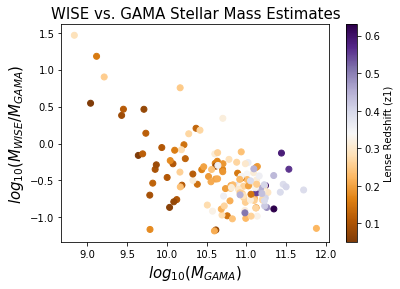

In [9]:
#--------------------------------------------------------------
# Import stellar masses from GAMA DR3 StellarMassesLambdar.fits
#--------------------------------------------------------------
hdul = fits.open('data/StellarMassesLambdar.fits')
gama_data = hdul[1].data

# Had to do this for FITS --> DataFrame conversion
gama_cataid = pd.DataFrame(np.array(gama_data["cataid"]).byteswap().newbyteorder())
gama_logMstar = pd.DataFrame(np.array(gama_data["logmstar"]).byteswap().newbyteorder())

# Data management
gama_merged_data=pd.merge(gama_cataid,gama_logMstar, left_index=True, right_index=True)
gama_merged_data["0_x"] = gama_merged_data["0_x"].astype(int) #Had to typecast to int
gama_merged_data.iscopy = False #avoids active override error
merged_data_logMstar = pd.merge(wise_data_final, gama_merged_data, how = 'left', left_on = 'cataid', right_on = '0_x')
gama_data_final = merged_data_logMstar.rename(columns={'cataid':'cataidWISE','0_x':'cataidGAMA','0_y':'logMstarGAMA'})

# Calculate WISE logMstar - GAMA logMstar
diffMstar = merged_data_logMstar.logMstarWISE-gama_data_final.logMstarGAMA

#------------------------------------------------------
# Plot the results
#------------------------------------------------------
p = plt.title("WISE vs. GAMA Stellar Mass Estimates",fontsize=15)
p = plt.scatter(gama_data_final.logMstarGAMA,diffMstar,c=z1_all_pairs, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Lense Redshift (z1)', fontsize=10)
p = plt.ylabel(r'$log_{10}(M_{WISE}/M_{GAMA})$', fontsize=15)
p = plt.xlabel(r'$log_{10}(M_{GAMA})$', fontsize=15)
# plt.savefig('WISE_vs_GAMA_Mstar.png',dpi=150)

# Redshift Profile Histograms

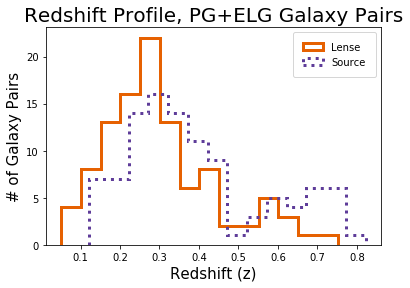

In [10]:
#------------------------------------------------------
#Redshift profile, all galaxy pairs from sample
#------------------------------------------------------
nbins = 30
binwidth = 0.05

# plt.hist(z1_all_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_all_pairs), max(z1_all_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_all_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_all_pairs), max(z2_all_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, All Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel(r'Redshift (z)', fontsize=15)

# plt.show()

#------------------------------------------------------
#Redshift profile, only PG+ELG galaxy pairs from sample
#------------------------------------------------------
plt.hist(z1_pg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_elg_pairs), max(z1_pg_elg_pairs) + binwidth, binwidth), label='Lense')
plt.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
plt.legend(loc='upper right', numpoints=2, borderpad=1)
p = plt.title("Redshift Profile, PG+ELG Galaxy Pairs",fontsize=20)
        
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.ylabel('# of Galaxy Pairs', fontsize=15)
plt.xlabel('Redshift (z)', fontsize=15)

# plt.savefig('PG_ELG_Gals_by_z.png')
plt.savefig('PG_ELG_Gals_by_z.png', dpi=90, bbox_inches='tight')
plt.show()

#------------------------------------------------------
#Redshift profile, only PG+PG galaxy pairs from sample
#------------------------------------------------------
# plt.hist(z1_pg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_pg_pairs), max(z1_pg_pg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_pg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_pg_pairs), max(z2_pg_pg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, PG+PG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#------------------------------------------------------
#Redshift profile, only ELG+PG galaxy pairs from sample
#------------------------------------------------------
# plt.hist(z1_elg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_pg_pairs), max(z1_elg_pg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_elg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_pg_pairs), max(z2_elg_pg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, ELG+PG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#-------------------------------------------------------
#Redshift profile, only ELG+ELG galaxy pairs from sample
#-------------------------------------------------------
# plt.hist(z1_elg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_elg_pairs), max(z1_elg_elg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_elg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_elg_pairs), max(z2_elg_elg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, ELG+ELG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#-----------------------------------------------------------
#Subplot for all spec. types: PG+ELG, ELG+PG, PG+PG, ELG+ELG
#-----------------------------------------------------------
# fig = plt.figure()
# fig.suptitle("Galaxy Pair Redshift Profiles by Spec. Type", fontsize=20)

# #PG+ELG Pairs
# ax1 = plt.subplot(221)
# ax1.hist(z1_pg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_elg_pairs), max(z1_pg_elg_pairs) + binwidth, binwidth), label='Lense')
# ax1.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
# ax1.set_title("Redshift Profile, PG+ELG Galaxy Pairs",fontsize=10)

# #ELG+PG Pairs
# ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
# ax2.hist(z1_elg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_pg_pairs), max(z1_elg_pg_pairs) + binwidth, binwidth), label='Lense')
# ax2.hist(z2_elg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_pg_pairs), max(z2_elg_pg_pairs) + binwidth, binwidth), label='Source')
# ax2.set_title("Redshift Profile, ELG+PG Galaxy Pairs",fontsize=10)
# ax2.legend(loc='upper center', bbox_to_anchor=(1.4, 1.1), numpoints=2, borderpad=1)

# #PG+PG Pairs
# ax3 = plt.subplot(223, sharex=ax1, sharey=ax1)
# ax3.hist(z1_pg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_pg_pairs), max(z1_pg_pg_pairs) + binwidth, binwidth), label='Lense')
# ax3.hist(z2_pg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_pg_pairs), max(z2_pg_pg_pairs) + binwidth, binwidth), label='Source')
# ax3.set_title("Redshift Profile, PG+PG Galaxy Pairs",fontsize=10)

# #ELG+ELG Pairs
# ax4 = plt.subplot(224, sharey=ax1)
# ax4.hist(z1_elg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_elg_pairs), max(z1_elg_elg_pairs) + binwidth, binwidth), label='Lense')
# ax4.hist(z2_elg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_elg_pairs), max(z2_elg_elg_pairs) + binwidth, binwidth), label='Source')
# ax4.set_title("Redshift Profile, ELG+ELG Galaxy Pairs",fontsize=10)

# #Additional subplot configuration
# fig.text(0.5, 0.04, 'Redshift (z)', ha='center', va='center', fontsize=15)
# fig.text(0, 0.5, '# of Galaxy Pairs', ha='center', va='center', rotation='vertical', fontsize=15)
# fig.subplots_adjust(top=0.82, bottom=0.18, left=0.10, right=0.95, hspace=0.95,
#                     wspace=0.35)
# # spaceplots([0,0,0,0], [.02,.02])
# plt.savefig('2by2_Gals_by_z.png', dpi=100, bbox_inches='tight')

# Comparison Plots

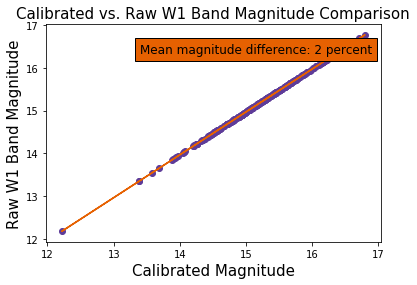

Text(0,0.5,'Source Redshift (z2)')

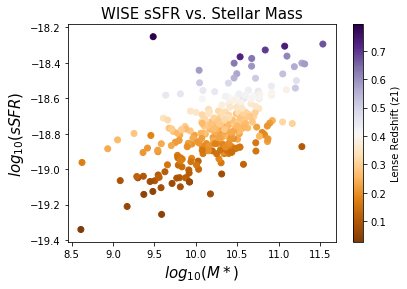

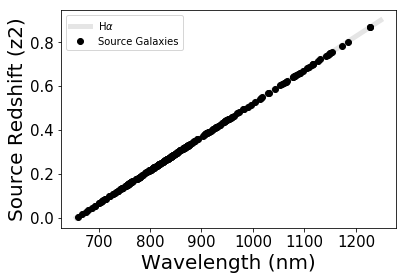

In [11]:
#------------------------------------------------------
# Calculate calibrated apparent magnitude
#------------------------------------------------------
# I was curious what the calibrated magnitude based on flux counts, aperture corrections, and instrumental zero point mags would be...
# See here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
m_zpt = 20.752
aper_corr = 0.222 # Found here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4c.html#circ
m_cal = m_zpt - 2.5*log10(w1flux_all_pairs)-aper_corr
#print(m_cal)

#------------------------------------------------------
# Calculate the mean of the raw vs. calibrated diff
#------------------------------------------------------
meanDiff=mean(abs(m_cal-w1_all_pairs))*100

#------------------------------------------------------
# Plot Mcal vs. Raw w1 mag
#------------------------------------------------------
plt.title("Calibrated vs. Raw W1 Band Magnitude Comparison",fontsize=15)
plt.scatter(m_cal,w1_all_pairs,color='#5e3c99')
m,c=np.polyfit(m_cal,w1_all_pairs,1)
plt.plot(m_cal,m*m_cal + c, color='#e66101')
plt.xlabel("Calibrated Magnitude",fontsize=15)
plt.ylabel("Raw W1 Band Magnitude",fontsize=15)
plt.text(13.4, 16.35, 'Mean magnitude difference: %d percent' %meanDiff, style='normal', fontsize=12, bbox={'facecolor':'#e66101', 'alpha':1, 'pad':5})
plt.show()

#------------------------------------------------------
# Plot sSFR vs. Mstar
#------------------------------------------------------
p = plt.title("WISE sSFR vs. Stellar Mass",fontsize=15)
p = plt.scatter((logMstar_all_pairs),(np.log10(sSFR_all_pairs)),c=z1_all_pairs, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Lense Redshift (z1)', fontsize=10)
p = plt.ylabel(r'$log_{10}(sSFR)$', fontsize=15)
p = plt.xlabel(r'$log_{10}(M*)$', fontsize=15)

#------------------------------------------------------
# Plot z2 vs. wavelength w/H_alpha 
#------------------------------------------------------

# Plot Halpha line first

lambdaHalpha = 656.86 # nm
z = np.arange(0,1,0.1)
ll = lambdaHalpha*(1+z)
plt.figure()
plt.subplot(111)
plt.title("")
plt.plot(ll,z,'k-',linewidth=5,label=r'H$\alpha$',alpha=0.1)


#Keck broadband filters z and J
# zbb = np.arange(999,1176,1)
# Jbb = np.arange(1180,1416,1)
# plt.fill_between(zbb, 0, 2, facecolor='orange', alpha=0.3)
# plt.fill_between(Jbb, 0, 2, facecolor='red', alpha=0.3)

plt.plot(lambdaHalpha*(1+z2_all_pairs), z2_all_pairs,'ko',label='Source Galaxies')
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('Stellar Mass (M*)', fontsize=10)

plt.legend()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)

plt.xlabel(r'Wavelength (nm)', fontsize=20)
plt.ylabel(r'Source Redshift (z2)', fontsize=20)
#plt.savefig('bandwidth_z.pdf',bbox_inches='tight')
#plt.savefig('bandwidth_z.png',bbox_inches='tight')

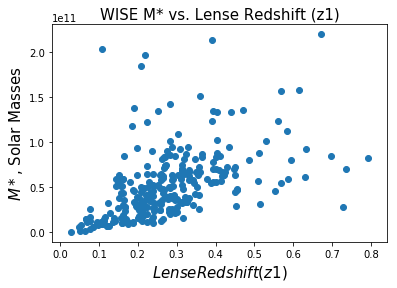

In [12]:
#------------------------------------------------------
# Plot Mstar vs. z1
#------------------------------------------------------
plt.title("WISE M* vs. Lense Redshift (z1)",fontsize=15)
plt.scatter(z1_all_pairs,Mstar_all_pairs)
plt.ylabel(r'$M*$, Solar Masses', fontsize=15)
plt.xlabel(r'$Lense Redshift (z1)$', fontsize=15)
plt.show()
#print(max(z1_all_pairs))
#plt.savefig('WISE_Mstar_vs_lense_z1.png')

# 2D Sky Projection

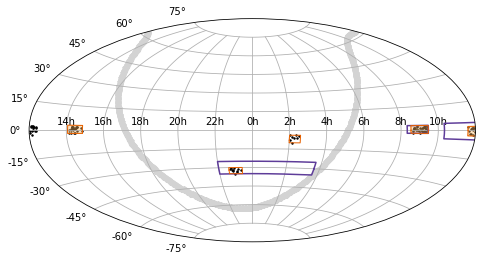

In [13]:
#----------------------------------------------------------------------
# Holwerda et al. (2015) PG+ELG candidates vs. KiDS, WISE, GAMA Surveys
#----------------------------------------------------------------------

# Read in ascii format, filter by PG+ELG pairs only
holwerda15_all_pairs = ap.io.ascii.read('data/holwerda15.csv')
holwerda15_pg_elg_pairs = holwerda15_all_pairs[holwerda15_all_pairs["spec_type"] == "PG+ELG"]

# Assign RA, Dec with proper units and wrap angle
holwerda15_ra = coord.Angle(holwerda15_pg_elg_pairs["ra"]*u.degree)
holwerda15_ra = holwerda15_ra.wrap_at(180*u.degree)
holwerda15_dec = coord.Angle(holwerda15_pg_elg_pairs["dec"]*u.degree)

# Set up box areas for KiDS North surveys 1 & 2, and KiDS South (Source: https://arxiv.org/pdf/1507.00742.pdf)
kids_n1x = np.array([240*np.pi/180,240*np.pi/180,155*np.pi/180,155*np.pi/180,240*np.pi/180,240*np.pi/180])
kids_n1y = np.array([0,4*np.pi/180,4*np.pi/180,-5*np.pi/180,-5*np.pi/180,0])

kids_n2x = np.array([142*np.pi/180,142*np.pi/180,125*np.pi/180,125*np.pi/180,142*np.pi/180,142*np.pi/180])
kids_n2y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])

kids_sx = np.array([55*np.pi/180,55*np.pi/180,-30*np.pi/180,-30*np.pi/180,55*np.pi/180,55*np.pi/180])
kids_sy = np.array([-30*np.pi/180,-25*np.pi/180,-25*np.pi/180,-35*np.pi/180,-35*np.pi/180,-30*np.pi/180])

# Set up box areas for GAMA survey (http://www.astro.ljmu.ac.uk/~ikb/research/gama_fields/)
gama_02x = np.array([30*np.pi/180,30*np.pi/180,39*np.pi/180,39*np.pi/180,30*np.pi/180,30*np.pi/180])
gama_02y = np.array([-8*np.pi/180,-4*np.pi/180,-4*np.pi/180,-10*np.pi/180,-10*np.pi/180,-8*np.pi/180,])

gama_09x = np.array([128*np.pi/180,128*np.pi/180,142*np.pi/180,142*np.pi/180,128*np.pi/180,128*np.pi/180])
gama_09y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])

gama_12x = np.array([174*np.pi/180,174*np.pi/180,186*np.pi/180,186*np.pi/180,174*np.pi/180,174*np.pi/180])
gama_12y = np.array([0,2*np.pi/180,2*np.pi/180,-3*np.pi/180,-3*np.pi/180,0])

gama_15x = np.array([-149*np.pi/180,-149*np.pi/180,-137*np.pi/180,-137*np.pi/180,-149*np.pi/180,-149*np.pi/180])
gama_15y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])
# print(gama_15y)


gama_23x = np.array([-21*np.pi/180,-21*np.pi/180,-9*np.pi/180,-9*np.pi/180,-21*np.pi/180,-21*np.pi/180])
gama_23y = np.array([-32*np.pi/180,-30*np.pi/180,-30*np.pi/180,-35*np.pi/180,-35*np.pi/180,-32*np.pi/180])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(holwerda15_ra.radian, holwerda15_dec.radian,color='#000000',s=2)
# ax.set_xticklabels(['23h','21h','19h','17h','15h','13h','11h','9h','7h','5h','3h','1h'])
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

# Plot KiDS survey areas
ax.plot(kids_n1x,kids_n1y,color='#5e3c99')
ax.plot(kids_n2x,kids_n2y,color='#5e3c99')
ax.plot(kids_sx,kids_sy,color='#5e3c99') #'#e66101'

# Plot GAMA survey areas
ax.plot(gama_02x,gama_02y,color='#e66101',linewidth=1)
# ax.fill(gama_02x,gama_02y,color='green',alpha=0.4)
ax.plot(gama_09x,gama_09y,color='#e66101',linewidth=1)
ax.fill(gama_09x,gama_09y,color='#fdb863',alpha=0.4)
ax.plot(gama_12x,gama_12y,color='#e66101',linewidth=1)
ax.fill(gama_12x,gama_12y,color='#fdb863',alpha=0.4)
ax.plot(gama_15x,gama_15y,color='#e66101',linewidth=1) 
ax.fill(gama_15x,gama_15y,color='#fdb863',alpha=0.4)
ax.plot(gama_23x,gama_23y,color='#e66101',linewidth=1) 

# Plotting the galactic plane (Source: http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html)

lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
gal_ra = eq_array[:,0]
gal_dec = eq_array[:,1]
x = np.remainder(gal_ra+360-180,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x 
ax.scatter(np.radians(x),np.radians(gal_dec),color="lightgray",marker='p')
# plt.savefig('2D_sky_map.png',dpi=500, transparent=True)

# Old but potentially useful stuff

In [14]:
# # all_pairs.count()
# # df.count()

# merged_data = pd.merge(df, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')

# # This relation comes from Cluver et al. (2014) p. 7 Eq (2)
# log_Mstar_Lum_W1 = -1.96*(merged_data.w1mpro - merged_data.w2mpro)-0.03

# ## My log(M*) doesn't look right...
# log_Mstar = 10**(-1.96*(merged_data.w1mpro - merged_data.w2mpro) - 0.03 - 0.4*(merged_data.w1mpro-3.24))
# #print(log_Mstar)

# ## Comparing log_Mstar to 0.6*W1...
# #Mstar_from_flux = 0.6*merged_data.w1mpro
# #print(Mstar_from_flux)

# observed_color_W1 = merged_data.w1mpro - merged_data.w2mpro #W1-W2
# observed_color_W3 = merged_data.w2mpro - merged_data.w3mpro #W2-W3

# WISE log(M/L) vs W1-W2, All Pairs (why so linear?)

In [15]:
# # Plotting all pairs, all redshifts
# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1,observed_color_W1, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
# #p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)

# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# log_Mstar_Lum_W1_lowz = -1.96*(merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro)-0.03
# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.4",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1_lowz,observed_color_W1_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.12

# log_Mstar_Lum_W1_lowestz = -1.96*(merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro)-0.03
# observed_color_W1_lowestz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
# observed_color_W3_lowestz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.12",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1_lowestz,observed_color_W1_lowestz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# # p = plt.yticks(np.arange(-0.2, 1, step=0.1))
# # p = plt.xticks(np.arange(-1.5, 0.5, step=1))
# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# WISE W1-W2 vs W2-W3, to compare with Cluver et al (2014) Figure 5

In [16]:
# # Plotting all pairs, all redshifts
# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1, observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
# #p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)

# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)